In [1]:
import sklearn

!pip install shap
import shap

# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Local interpretation

In [2]:
# 단일 SHAP Force plot

# 1) Explainer 만들기 (배경 데이터: X100)
explainer = shap.Explainer(model, X100)

# 2) SHAP 값 계산 (설명할 데이터)
shap_values = explainer(X)   # 또는 explainer(X.iloc[:50]) 처럼 일부만

# 3) Force plot (단일 샘플)
shap.initjs()  # 코랩/주피터에서 인터랙티브 렌더링용

i = 0  # 보고 싶은 인덱스
shap.plots.force(shap_values[i])   # (new API)

In [3]:
# 앞 50개를 stacked force plot 스타일
shap.plots.force(shap_values[:50])

In [4]:
# legacy 스타일
shap.force_plot(
    explainer.expected_value,
    shap_values[i].values,
    X.iloc[i]
)

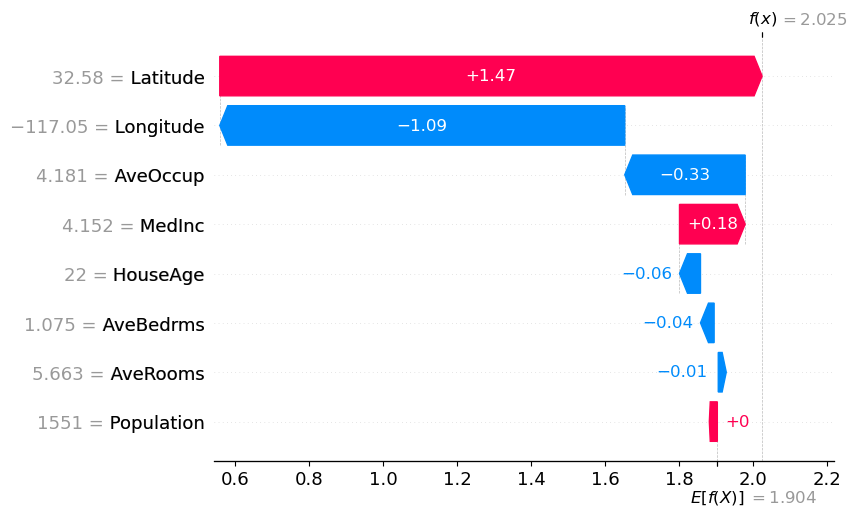

In [ ]:
# waterfall plot
shap.plots.waterfall(shap_values[0])

---

## Local interpretation VS LIME

- SHAP → 이론적으로 정당한 feature 기여도 분배 방법 (게임이론 기반)  
- LIME → 해당 지점 주변에서 단순 모델로 근사해서 설명하는 방법  

| 구분      | SHAP                 | LIME                  |
| ------- | -------------------- | --------------------- |
| 핵심 아이디어 | Shapley value (게임이론) | Local surrogate model |
| 설명 방식   | 기여도를 공정하게 분배         | 주변에서 선형 모델로 근사        |
| 이론적 보장  | 있음 (공정성 공리 만족)       | 없음 (근사 모델 기반)         |
| 계산 방식   | 조합 기반 기여 계산          | 샘플링 후 회귀              |
| 실행할 때마다 결과 동일 | ✔ 거의 동일 | 샘플링에 따라 달라질 수 있음 |
| 계산량           | 많음      | 상대적으로 적음           |
| 속도            | 느릴 수 있음 | 빠름                 |

🎯 SHAP  
“각 feature가 이 예측에 얼마나 기여했는지 공정하게 계산”  
→ 분해 결과가 정확히 예측값과 일치  
→ additive explanation  

🎯 LIME  
“이 점 근처에서 선형 모델로 근사하면 어떻게 설명될까?”  
→ 실제 모델을 단순화해서 설명  
→ 완벽히 일치하지 않을 수도 있음  

---

## LIME

In [16]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283918 sha256=7576ab1ae374d4553ae948eda175e596d4c411059a64d911628e754fb6307ee9
  Stored in directory: c:\users\jm\appdata\local\pip\cache\wheels\7c\04\5c\157dc9106512a6c7a30653ec064490c94a49e0fc8f63d19ab9
Successfully built lime


Prediction: 2.9301255817221445
SHAP base value: 2.135186020913764
SHAP sum contrib: 0.7949395608083785
Base + sum: 2.9301255817221428


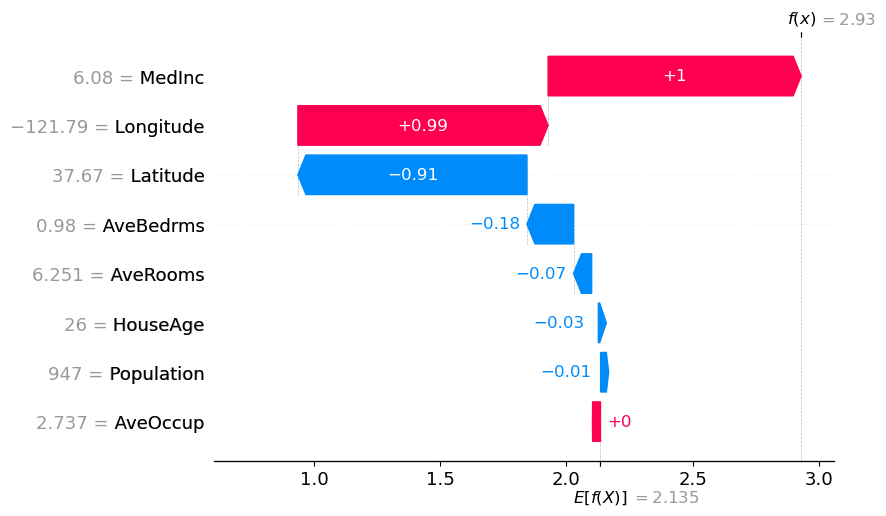


LIME explanation (feature -> contribution):
MedInc > 4.72                       +1.9179
Longitude <= -121.75                +1.6401
AveRooms > 6.02                     -0.7927
AveBedrms <= 1.01                   -0.3591
34.22 < Latitude <= 37.71           -0.3179
2.43 < AveOccup <= 2.80             +0.1134
816.00 < Population <= 1164.00      -0.0739
18.00 < HouseAge <= 28.00           -0.0578


c:\Users\jm\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


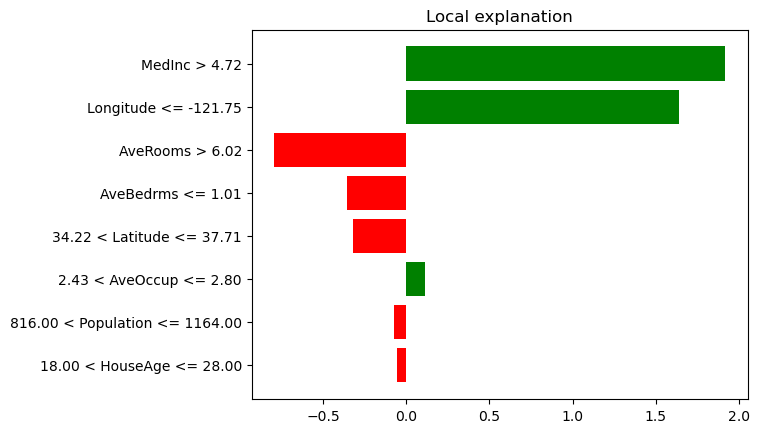

In [19]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import shap
from lime.lime_tabular import LimeTabularExplainer

# 1) 데이터 + 모델 학습
X, y = shap.datasets.california(n_points=2000)  # 회귀 데이터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# 설명 대상 샘플 (테스트에서 하나 선택)
idx = 0
x = X_test.iloc[idx]          # pandas Series
x_row = X_test.iloc[[idx]]    # 2D (DataFrame)

pred = model.predict(x_row)[0]
print("Prediction:", pred)

# 2) SHAP (Local explanation)
# 배경 데이터(평균/기준값 계산에 필요). 보통 train에서 샘플링
X_bg = shap.utils.sample(X_train, 100, random_state=42)

explainer = shap.Explainer(model, X_bg)
shap_values = explainer(X_test)       # 전체 테스트에 대한 SHAP 값
sv = shap_values[idx]                 # idx 샘플 1개

print("SHAP base value:", sv.base_values)
print("SHAP sum contrib:", sv.values.sum())
print("Base + sum:", sv.base_values + sv.values.sum())

# SHAP Waterfall (추천: 논문/리포트에 해석이 가장 깔끔)
shap.plots.waterfall(sv, max_display=10)

# (옵션) SHAP Force Plot - 노트북에서 인터랙티브로 보기 좋음
# shap.plots.force(sv)  # 환경에 따라 렌더링 방식이 다를 수 있음

# 3) LIME (Local surrogate model)
# LIME은 numpy 기반이 편함
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode="regression",
    discretize_continuous=True,   # 연속형 변수를 구간화해서 안정적으로 설명
    random_state=42
)

exp = explainer_lime.explain_instance(
    data_row=x.values,
    predict_fn=model.predict,
    num_features=10
)

# LIME 결과 텍스트로 보기
print("\nLIME explanation (feature -> contribution):")
for feat, weight in exp.as_list():
    print(f"{feat:35s} {weight:+.4f}")

# LIME plot
fig = exp.as_pyplot_figure()


- SHAP 그래프  
MedInc가 +1만큼 올림  
Latitude가 -0.91만큼 내림  
이 모든 값 합쳐서 2.93 도달  
→ 완전한 분해  

- LIME 그래프  
MedInc > 4.72 조건이 +1.9179  
Longitude 조건이 +1.6401  
AveRooms가 -0.79  
→ “조건 기반 설명”  

<BIG>**🎯 분석**</BIG>


전체 데이터에 대한 모델의 평균 예측값(SHAP base value: 2.135)보다  
로컬 모델이 실제 예측한 최종 예측값(Prediction: 2.93)이 더 높게 예측되었다.  
- SHAP → 2.93을 정확히 분해
- LIME → 2.93을 근사해서 설명

<br>

이는 SHAP & LIME 그래프에서 볼 수 있듯이  
중간 소득(MedInc) 과 위치 변수(Longitude) 의 강한 양(+)의 기여 때문이다.  
반면, 위도(Latitude), 평균 침실 수(AveBedrms) 등은 일부 가격을 낮추는 방향으로 작용하였으나,  
상승 요인의 영향이 더 커 최종적으로 높은 가격이 예측되었다.  
- SHAP: 평균 2.135에서  
MedInc가 +1, Longitude가 +0.99 … 해서 2.93로 최종 예측  
- LIME:  
MedInc > 4.72라서 가격이 오르고,  
Longitude 조건 때문에 또 오르고 … 그래서 평균 2.135보다 높게 나온 것으로 최종 예측  
